In [1]:
import numpy as np
from scipy.sparse import rand as sprand
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from itertools import product
import networkx as nx

seed = 1234
rng = np.random.default_rng(seed=seed) # Seed random number generator

def cart_prod(row_idxs, col_idxs):
    return [np.array(elt) for elt in zip(*product(row_idxs, col_idxs))]

def negative_sample_bipartite(n_samples, n_rows, n_cols, obs_pairs):
    # Sample subset of unobserved pairs
    unobs_pairs = []
    while len(unobs_pairs) < n_samples:
        i = rng.integers(0, n_rows)
        j = rng.integers(0, n_cols)

        if (i, j) not in obs_pairs:
            unobs_pairs.append((i, j))

    return unobs_pairs

In [16]:
# Params

n_users = 1_00
n_items = 1_00
n_epochs = 1000
bs = 1 # Batch size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
density = 0.01
unobs_multiple = 0
n_obs = int(n_users * n_items * density)
k = 2
# n_unobs_to_sample = int(n_obs * unobs_multiple)
train_split = 0.8
# last_obs_idx = int(n_obs * train_split)
# last_unobs_idx = int(n_unobs_to_sample * train_split)


In [6]:


# obs_rows = rng.integers(0, n_users, size=(n_obs,))
# obs_cols = rng.integers(0, n_items, size=(n_obs,))
# obs_pairs = list(zip(obs_rows, obs_cols))





# # Train test split
# obs_pairs_train, obs_pairs_test = np.array(obs_pairs[:last_obs_idx]), np.array(obs_pairs[last_obs_idx:])
# unobs_pairs_train, unobs_pairs_test = np.array(unobs_pairs[:last_unobs_idx]).reshape(-1, 2), np.array(unobs_pairs[last_unobs_idx:]).reshape(-1, 2) # Reshape in case empty

# train_data = np.vstack((obs_pairs_train, unobs_pairs_train)).astype(int)
# test_data = np.vstack((obs_pairs_test, unobs_pairs_test)).astype(int)
# ratings = np.zeros(shape=(n_users, n_items))
# ratings[obs_rows, obs_cols] = 1

# # Netflix
# ratings = sprand(n_users, n_items, density=density, format="csr")
# ratings.data = np.random.randint(1, 5, size=ratings.nnz).astype(np.float64)
# ratings = ratings.toarray()
# obs_pairs = np.vstack(ratings.nonzero()).T
# train_data = obs_pairs[:last_obs_idx]
# test_data = obs_pairs[last_obs_idx:]


In [17]:
# Generate adjacency matrix

graph_type = 'knn' # random netflix knn

if graph_type == 'lattice':
    lattice2d = nx.grid_2d_graph(np.sqrt(n_users).astype(int), np.sqrt(n_items).astype(int))
    ratings = nx.adjacency_matrix(lattice2d)
    ratings = ratings.toarray()
    obs_pairs = list(zip(*ratings.nonzero()))

elif graph_type == 'knn':
    obs_pairs = []
    for i in range(n_users):
        for j in range(max(0, i - k), min(i + k, n_items)):
            obs_pairs.append((i, j))

    ratings = np.zeros(shape=(n_users, n_items))
    nz_rows, nz_cols = [np.array(elt) for elt in list(zip(*obs_pairs))]
    ratings[nz_rows, nz_cols] = 1


# Train test split
last_obs_idx = int(n_obs * train_split)
# last_unobs_idx = int(n_unobs * train_split)
obs_pairs = rng.permutation(obs_pairs)
obs_pairs_train, obs_pairs_test = obs_pairs[:last_obs_idx], obs_pairs[last_obs_idx:]
obs_pairs_train, obs_pairs_test = np.array(obs_pairs[:last_obs_idx]), np.array(obs_pairs[last_obs_idx:])
# unobs_pairs_train, unobs_pairs_test = np.array(unobs_pairs[:last_unobs_idx]).reshape(-1, 2), np.array(unobs_pairs[last_unobs_idx:]).reshape(-1, 2) # Reshape in case empty
# train_data = np.vstack((obs_pairs_train, unobs_pairs_train)).astype(int)
# test_data = np.vstack((obs_pairs_test, unobs_pairs_test)).astype(int)
test_data = np.array(obs_pairs_test).astype(int)
obs_pairs = [tuple(elt) for elt in obs_pairs] # Back to this for negative sampling later


In [36]:
class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=False)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=False)
        self.user_biases = torch.nn.Embedding(n_users, 1, sparse=False)
        self.item_biases = torch.nn.Embedding(n_items, 1, sparse=False)

        # self.user_factors.weight = self.scale_embed(self.user_factors.weight)
        # self.item_factors.weight = self.scale_embed(self.item_factors.weight)

        # torch.nn.init.normal_(self.user_biases.weight, mean=0, std=3e-1)
        # torch.nn.init.normal_(self.item_biases.weight, mean=0, std=1e-1)
        # torch.nn.init.normal_(self.user_factors.weight, mean=0, std=1e-1)
        # torch.nn.init.normal_(self.item_factors.weight, mean=0, std=1e-1)

    def forward(self, user, item):
        pred = (self.user_factors(user) * self.item_factors(item)).sum(dim=1, keepdim=True) # + self.user_biases(user) + self.item_biases(item)
        return pred
        # return torch.sigmoid(pred)
    
    def scale_embed(self, embedding):
        np_embed = embedding.detach().numpy()
        np_embed /= np.linalg.norm(np_embed, axis=1).reshape(-1,1)
        return torch.nn.Parameter(torch.FloatTensor(np_embed))
    
model = MatrixFactorization(n_users, n_items, n_factors=5).to(device)

# loss_func = torch.nn.MSELoss()
loss_func = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, weight_decay=1e-3)  # learning rate

In [37]:
all_users, all_items = [torch.LongTensor(elt) for elt in cart_prod(np.arange(n_users), np.arange(n_items))]
prior_beliefs = model(all_users, all_items).detach().numpy().reshape(n_users, n_items)


In [38]:
# Train

loss_curve = []
test_loss_curve = []
test_target = torch.FloatTensor(ratings[test_data[:,0], test_data[:,1]]).reshape(test_data.shape[0], 1)
test_row, test_col = [torch.LongTensor(elt, device=device) for elt in (test_data[:,0], test_data[:,1])]
for ep in range(n_epochs):

    # Negative sampling
    n_obs = len(obs_pairs_train)
    n_unobs = int(n_obs * unobs_multiple)
    unobs_pairs = negative_sample_bipartite(n_unobs, n_users, n_items, obs_pairs_train)

    # Batch train data
    train_data = np.vstack((np.array(obs_pairs_train), np.array(unobs_pairs).reshape(-1, 2))).astype(int)
    dl = DataLoader(train_data, batch_size=bs, shuffle=True)
    epoch_loss = []
    test_epoch_loss = []
    for i, batch in enumerate(dl):
        # Set gradients to zero
        optimizer.zero_grad()
        batch = batch.to(device)
        row, col = batch[:,0], batch[:,1]

        target = ratings[row, col].reshape(bs, 1)

        target = torch.FloatTensor(target, device=device)
        
        # Predict and calculate loss
        prediction = model(row, col)
        loss = loss_func(prediction, target)
        test_prediction = model(test_row, test_col)
        test_loss = loss_func(test_prediction, test_target)

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

        epoch_loss.append(loss.item())
        test_epoch_loss.append(test_loss.item())

    epoch_loss = np.array(epoch_loss)
    test_epoch_loss = np.array(test_epoch_loss)
    loss_curve.append((epoch_loss.mean(), epoch_loss.std()))
    test_loss_curve.append((test_epoch_loss.mean(), test_epoch_loss.std()))
    print(f"Epoch: {ep}. Train loss: {loss_curve[-1][0]}, Test loss: {test_loss_curve[-1][0]}")

Epoch: 0. Train loss: 0.7291641768068076, Test loss: 0.7444797083735466
Epoch: 1. Train loss: 0.7263783786445857, Test loss: 0.7444021068513393
Epoch: 2. Train loss: 0.7236398857086896, Test loss: 0.7443182215094566
Epoch: 3. Train loss: 0.7209133561700583, Test loss: 0.7442363888025284
Epoch: 4. Train loss: 0.7182226799428463, Test loss: 0.7441486857831479
Epoch: 5. Train loss: 0.7155445598065853, Test loss: 0.7440769396722317
Epoch: 6. Train loss: 0.7129140932112932, Test loss: 0.7439861871302128
Epoch: 7. Train loss: 0.7102897986769676, Test loss: 0.743898493796587
Epoch: 8. Train loss: 0.707693887501955, Test loss: 0.7438069567084312
Epoch: 9. Train loss: 0.705125242844224, Test loss: 0.7437391601502895
Epoch: 10. Train loss: 0.7025734301656484, Test loss: 0.7436514496803284
Epoch: 11. Train loss: 0.7000423330813647, Test loss: 0.7435851939022541
Epoch: 12. Train loss: 0.6975431710481643, Test loss: 0.7435094319283962
Epoch: 13. Train loss: 0.6950541008263826, Test loss: 0.74346327

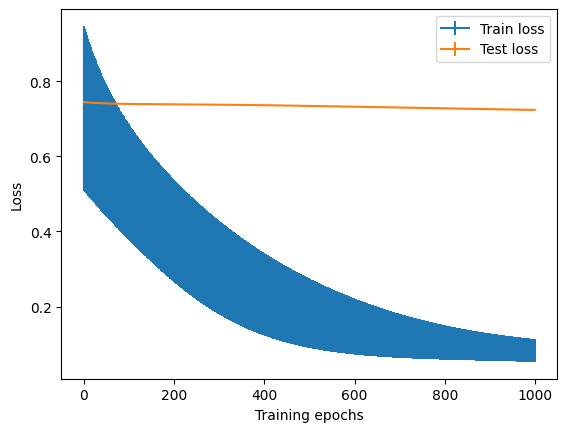

In [39]:
ave_loss, std_loss = list(zip(*loss_curve))

plt.errorbar(x=np.arange(n_epochs), y=ave_loss, yerr=std_loss, label="Train loss")
ave_loss, std_loss = list(zip(*test_loss_curve))
plt.errorbar(x=np.arange(n_epochs), y=ave_loss, yerr=std_loss, label="Test loss")
plt.xlabel('Training epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

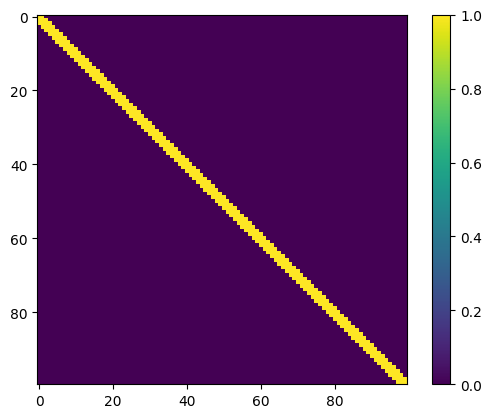

In [34]:
plt.imshow(ratings)
plt.colorbar()

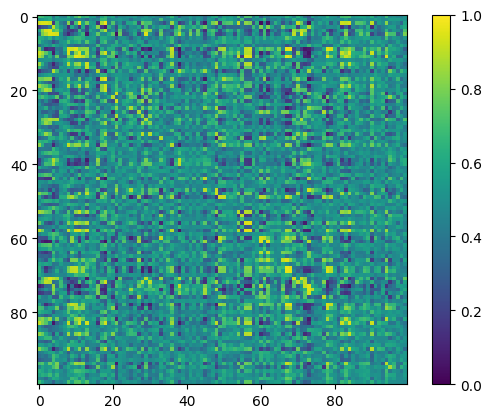

In [40]:
all_users, all_items = [torch.LongTensor(elt) for elt in cart_prod(np.arange(n_users), np.arange(n_items))]

y_pred = model(all_users, all_items).detach().numpy().reshape(n_users, n_items)

plt.imshow(y_pred)
plt.colorbar()
plt.clim(0,1)

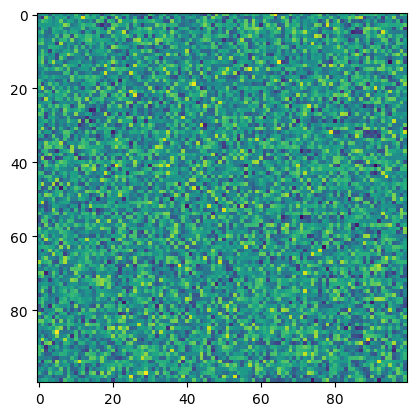

In [15]:
plt.imshow(prior_beliefs)

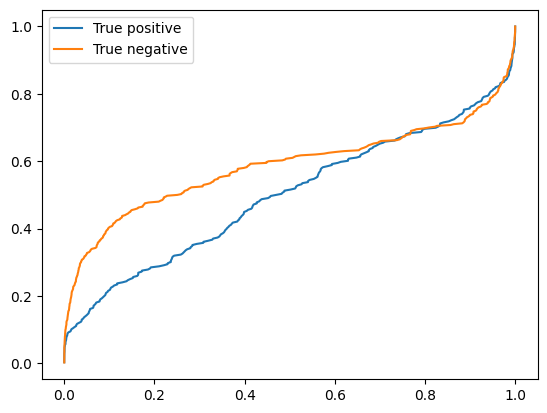

In [200]:
test_prediction = model(test_row, test_col).detach().numpy() # Final prediction

# Sample subset of unobserved pairs
unobs_pairs = negative_sample_bipartite(n_unobs, n_users, n_items, obs_pairs)

unobs_pairs = torch.LongTensor(unobs_pairs)
tn_pred = model(unobs_pairs[:,0], unobs_pairs[:,1]).detach().numpy()

labels = ["True positive", "True negative"]
datas = [test_prediction, tn_pred]
for i in range(len(datas)):
    data = datas[i].reshape(-1, )
    xcdf = sorted(data)
    ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
    plt.plot(xcdf, ycdf, label=labels[i])

plt.legend()
plt.show()

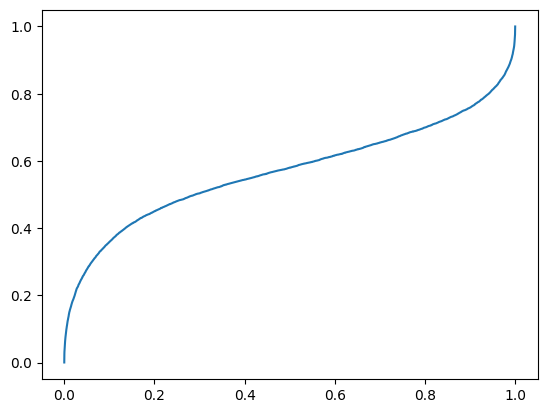

In [124]:
xcdf = sorted(y_pred.reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf)

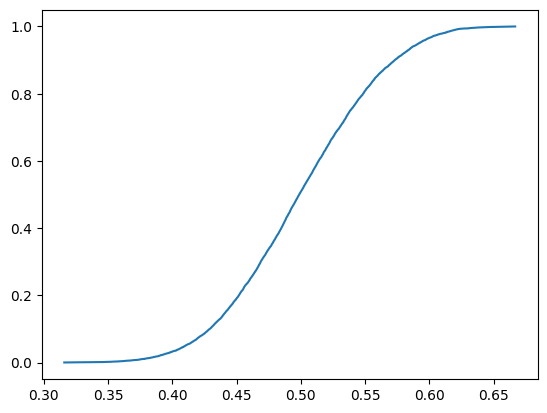

In [223]:
xcdf = sorted(prior_beliefs.reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf)

ValueError: not enough values to unpack (expected 2, got 0)

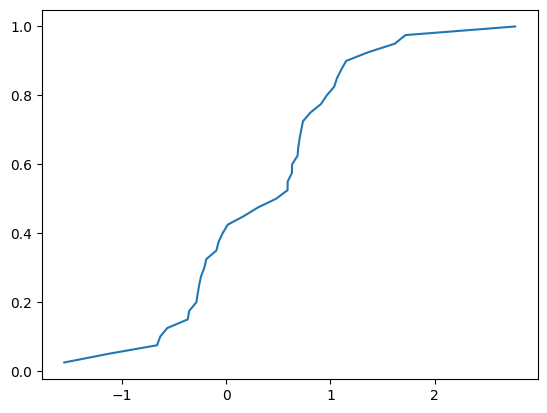

In [29]:
xcdf = sorted(y_pred[obs_pairs_test[:,0], obs_pairs_test[:,1]].reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf, label='True pos')

unobs_rows, unobs_cols = list(zip(*unobs_pairs))
xcdf = sorted(y_pred[unobs_rows, unobs_cols].reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf, label='True neg')
plt.xlim(0,1)
plt.legend()
plt.show()

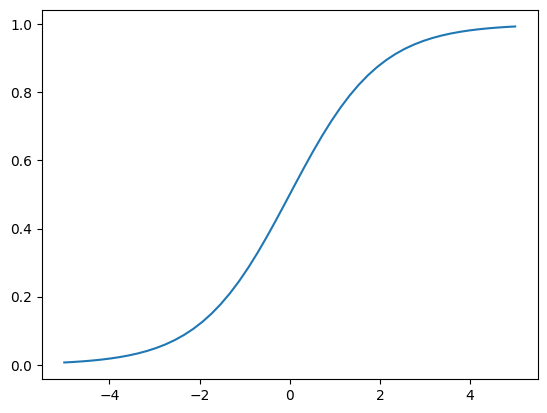

In [787]:
def sigmoid(x, a):
    return 1 / (1 + np.exp(-a * (x)))

a = 1
x = np.linspace(-5, 5)
y = sigmoid(x, a)
plt.plot(x, y)

(-5.0, 5.0)

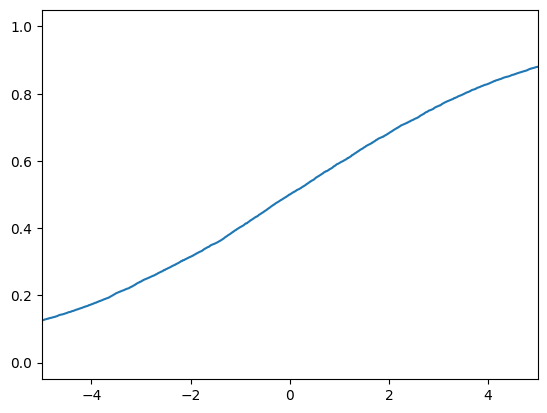

In [189]:
mu = 0
scl = 1e0
n = 100
n_factors = 20

u = rng.normal(loc=mu, scale=scl, size=(n, n_factors))
v = rng.normal(loc=mu, scale=scl, size=(n, n_factors))
cos = (u @ v.T)
xcdf = sorted(cos.reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf)
plt.xlim(-5,5)

(-5.0, 5.0)

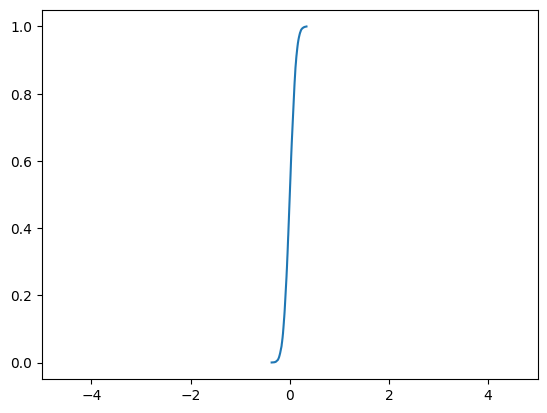

In [44]:
mu = 0
scl = 1e-1
n = 100

u = rng.normal(loc=mu, scale=scl, size=(n*n,))
xcdf = sorted(u.reshape(-1,))
ycdf = np.arange(1, len(xcdf)+1) / len(xcdf)
plt.plot(xcdf, ycdf)
plt.xlim(-5,5)